In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2022 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Gemma Fardell (UKRI-STFC)
#                   Jakob S. Jørgensen (DTU)           

In [2]:
from cil.framework import AcquisitionGeometry

from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import ZeroFunction, LeastSquares

from cil.io import TIFFStackReader

from cil.processors import TransmissionAbsorptionConverter, Binner, Normaliser

from cil.plugins.tigre import ProjectionOperator
from cil.recon import FDK

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

import numpy as np
import os

astropy module not found


# Laminography reconstruction with TV regularisation using FISTA

This exercise uses CIL to reconstruct a Laminography dataset - that is a dataset with a tilted rotation axis. 

Laminography scanning is commonly used for large thin samples like circuit boards. In conventional CT these samples lead to widely varying path-lengths as the sample rotates. By tilting the sample and rotating it around a vector perpendicular to the sample plane the path-lengths stay relatively constant. However, this geometry leads to some artefacts in the reconstruction from the missing data. These artefacts are particularly prevelant when you look at a slice out of the sample plane.

By using regularisation, we can suppress these artefacts. This notebook compares FDK, least-squares without regularisation using FISTA and least-squares with Total Variation regularisation also using FISTA. 

A laminography dataset of a LEGO phantom acquired at The Henry Moseley X-ray Imaging Facility at The University of Manchester, UK, is used.

**Learning objectives:**

1. Construct an advanced AcquistionGeometry by-hand to describe the tilted and offset data

2. Use this geometry to read in a tiff stack and create an AcquisitionData object

3. Create a custom ImageGeometry around the flat sample

4. Reconstruct the data with LS and TV

### Data

This example requires `CLProjectionData.zip` and `CLShadingCorrection.zip` from https://zenodo.org/record/2540509

https://zenodo.org/record/2540509/files/CLProjectionData.zip

https://zenodo.org/record/2540509/files/CLShadingCorrection.zip

Once downloaded update `path_common` to run the script.

In [3]:
#Set the path to the directory containing the data
path_common = '/remfs/learnmore/nbgrader/exchange/data/CIL/Laminography'


## Create the acquisition geometry

We know the system parameters from the paper and author clarification. We use this to set up a 3D cone-beam geometry with the rotation axis tilited 30 degrees towards the source.


In [4]:
#parameters are from the original paper/author clarification
src_to_det = 967.3209839
src_to_object = 295
tilt = 30. * np.pi / 180.
centre_of_rotation = 0.254 * 6.

mag = src_to_det / src_to_object 
object_offset_x = centre_of_rotation / mag

source_pos_y = -src_to_object
detector_pos_y = src_to_det-src_to_object
angles_list = -np.linspace(0, 360, 2513, endpoint=False)
num_pixels_x = 1596
num_pixels_y = 1148
pixel_size_xy = 0.254

We create the CIL Cone3D `AcquisitionGeometry`, `ag`, and print it for information and also display it:

3D Cone-beam tomography
System configuration:
	Source position: [   0., -295.,    0.]
	Rotation axis position: [0.46476817, 0.        , 0.        ]
	Rotation axis direction: [ 0.       , -0.5      ,  0.8660254]
	Detector position: [  0.   , 672.321,   0.   ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1596 1148]
	Pixel size: [0.254 0.254]
	Pixel origin: top-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 2513
	Angles 0-20 in degrees:
[-0.        , -0.14325507, -0.28651014, -0.42976522, -0.5730203 ,
 -0.7162754 , -0.85953045, -1.0027856 , -1.1460406 , -1.2892957 ,
 -1.4325508 , -1.5758058 , -1.7190609 , -1.862316  , -2.0055711 ,
 -2.1488261 , -2.292081  , -2.4353364 , -2.5785913 , -2.7218463 ]



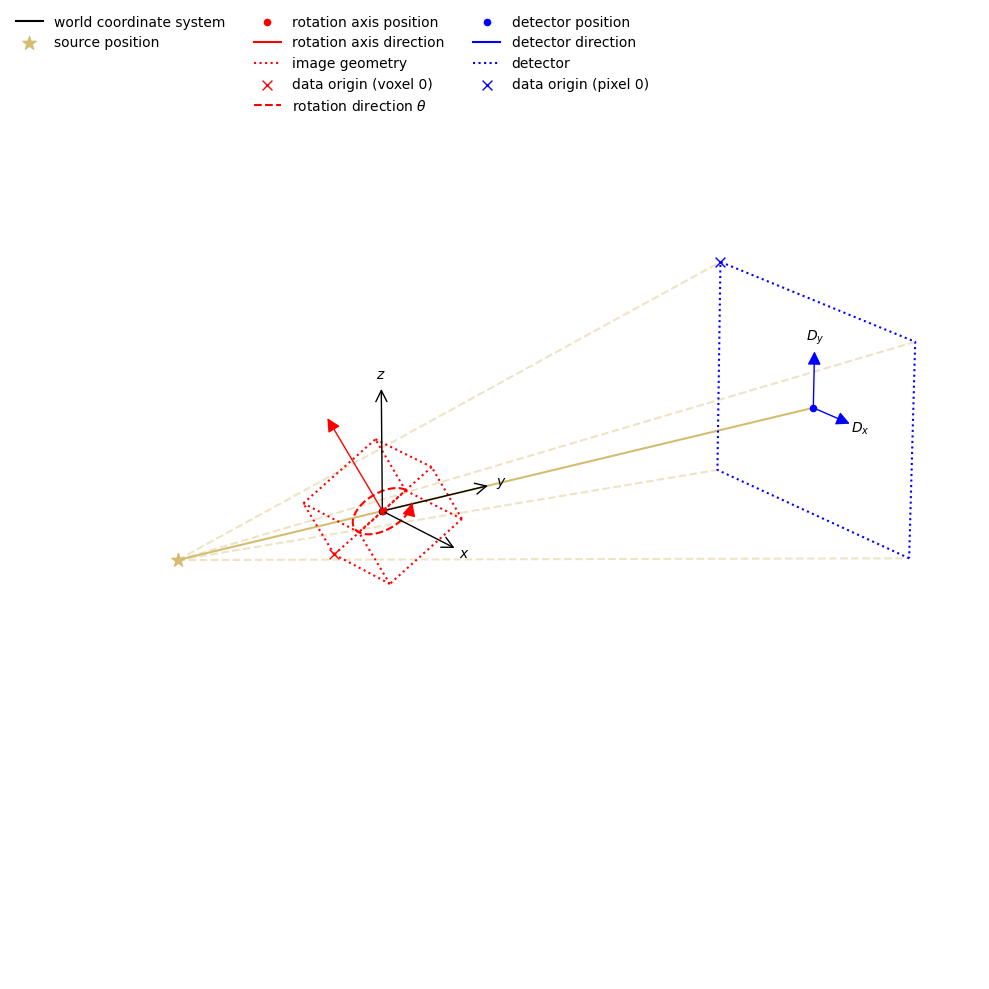

In [5]:
ag = AcquisitionGeometry.create_Cone3D( source_position=[0.0, source_pos_y,0.0], \
                                        detector_position=[0.0, detector_pos_y,0.0],\
                                        rotation_axis_position=[object_offset_x,0,0],\
                                        rotation_axis_direction=[0,-np.sin(tilt), np.cos(tilt)] ) \
                        .set_angles(angles=angles_list, angle_unit='degree')\
                        .set_panel( num_pixels=[num_pixels_x, num_pixels_y], \
                                    pixel_size=pixel_size_xy,\
                                    origin='top-left')\
                        .set_labels(['angle','vertical','horizontal'])
print(ag)
show_geometry(ag)

# Read in the data
We will start by reading in data from a stack of tiffs. As we read in the data we will symmetrically crop and down-sample the data. We will remove a 100 pixel border from each projection, and we will only read in every 7th projection. This significantly reduces the computational time and memory cost without a loss of reconstruction quality.

To specify the part of the full data to read in, the `TIFFStackReader` uses the default labels 'axis_0', 'axis_1' and 'axis_2' to refer to the dimensions of the TIFF stack, being files, vertical and horizontal pixels, respectively.

We want to crop in the horizontal and vertical directions, and slice the angles direction. We create a region of interest (RoI) dictionary `roi` with the axis name, and a tuple containing the starting pixel index, the end pixel index and the step size to slice.

We also need to update the geometry to account for the new panel size.


In [6]:
crop = 100

roi = {'axis_0': (None, None, 7),
       'axis_1': (crop, -crop, None), 
       'axis_2': (crop, -crop, None)}

num_pixels_x = (1596 - 2*crop)
num_pixels_y = (1148 - 2*crop)
pixel_size_xy = 0.254

angles_list = -np.linspace(0, 360, int(2513/7), endpoint=False)

ag.set_angles(angles_list)
ag.set_panel(num_pixels=[num_pixels_x,num_pixels_y],pixel_size=pixel_size_xy,origin='top-left')
       

From `cil.io` we import and create a `TIFFStackReader` instance to read in the data, this is created with the directory path and the RoI dictionary defined above.

As we have already defined our acquisition geometry we can use the function `read_as_AcquisitionData()` to pass this to the reader. The reader will use this to configure and return an `AcquisitionData` object containing the data and the geometry describing it.

In [7]:
path = 'Lego_Lamino30deg_XTH/'

reader = TIFFStackReader(file_name=os.path.join(path_common, path), roi=roi, mode='slice')
acq_data_raw = reader.read_as_AcquisitionData(ag)

islicer(acq_data_raw, direction='angle', origin='upper-left')


interactive(children=(IntSlider(value=179, continuous_update=False, description='angle', max=358), FloatRangeS…

IntSlider(value=179, continuous_update=False, description='angle', max=358)

We now read in the dark and flat field images and use these to normalise the data. We need to crop these tiffs with the same RoI as previously. We now can use use `read()` here to simply read in the tiffs and return a numpy array which we delete after applying to the data.

In [8]:
tiffs = [   os.path.join(path_common,'Lego_Lamino30deg_ShadingCorrection_XTH/Dark_80kV85uA.tif'),
            os.path.join(path_common,'Lego_Lamino30deg_ShadingCorrection_XTH/Flat_80kV85uA.tif') ]

roi = {'axis_0': (None, None, None),
       'axis_1': (crop, -crop, None), 
       'axis_2': (crop, -crop, None)}

reader = TIFFStackReader(file_name=tiffs, roi=roi)
dark_flat_data = reader.read()

normaliser = Normaliser(dark_flat_data[1], dark_flat_data[0])
acq_data_SC = normaliser(acq_data_raw)

islicer(acq_data_SC, direction='angle',origin='upper-left')

del acq_data_raw
del dark_flat_data

interactive(children=(IntSlider(value=179, continuous_update=False, description='angle', max=358), FloatRangeS…

Finally we convert the intensity data to attenuation data using the Beer-Lambert law

In [9]:
converter = TransmissionAbsorptionConverter()
acq_data_atten = converter(acq_data_SC)

islicer(acq_data_atten, direction='angle',origin='upper-left')

del acq_data_SC

interactive(children=(IntSlider(value=179, continuous_update=False, description='angle', max=358), FloatRangeS…

We will run this notebook over 4x binned data for speed. The iterative reconstructions will take approximately 5 minutes at this binning.

We use CIL's Binner processor to average together every 4 pixels in the horizontal and vertical directions.

We define the RoI using the same syntax as previously, however now we set our start and stop indices to `None` as we want to include the full width of the data.

In [10]:
#bin the data for speed 
binning = 4

roi = {'horizontal': (None, None, binning),
       'vertical': (None, None, binning)}
acq_data = Binner(roi=roi)(acq_data_atten)

#note the number of pixels and pixel size is updated for you
print(acq_data.geometry)

islicer(acq_data, direction='angle', origin='upper-left')
del acq_data_atten

3D Cone-beam tomography
System configuration:
	Source position: [   0., -295.,    0.]
	Rotation axis position: [0.46476817, 0.        , 0.        ]
	Rotation axis direction: [ 0.       , -0.5      ,  0.8660254]
	Detector position: [  0.   , 672.321,   0.   ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [349 237]
	Pixel size: [1.016 1.016]
	Pixel origin: top-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 359
	Angles 0-20 in degrees:
[ -0.       ,  -1.0027856,  -2.0055711,  -3.0083566,  -4.0111423,
  -5.0139275,  -6.016713 ,  -7.019499 ,  -8.0222845,  -9.025069 ,
 -10.027855 , -11.030641 , -12.033426 , -13.036212 , -14.038998 ,
 -15.041782 , -16.044569 , -17.047354 , -18.050138 , -19.052925 ]



interactive(children=(IntSlider(value=179, continuous_update=False, description='angle', max=358), FloatRangeS…

## Reconstructing the data using FDK

As we are using the TIGRE backend we don't need to reorder the data for use by TIGRE. If we were using ASTRA as the backend we would need to use `acq_data.reorder('astra')` to permute the data ready for ASTRA.

We use CIL's `recon.FDK` to reconstruct the data. We configure a `reconstructor` object, and then call the `run` method. 

In [11]:
reconstructor = FDK(acq_data)
FDK_reco = reconstructor.run()

FDK recon

Input Data:
	angle: 359
	vertical: 237
	horizontal: 349

Reconstruction Volume:
	vertical: 237
	horizontal_y: 349
	horizontal_x: 349

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 10
	Filter_inplace: False



And we can view the results slicing in different orientations:

In [12]:
islicer(FDK_reco, direction='horizontal_y')

interactive(children=(IntSlider(value=174, continuous_update=False, description='horizontal_y', max=348), Floa…

IntSlider(value=174, continuous_update=False, description='horizontal_y', max=348)

We used the default `ImageGeometry` so we see a lot of empty space. Reconstructing empty voxels becomes costly over many iterations. If we collapse the data along the Z and Y axes by picking out the pixelwise maximum value along those axes, we can clearly identify a sufficient reconstruction window around the sample.

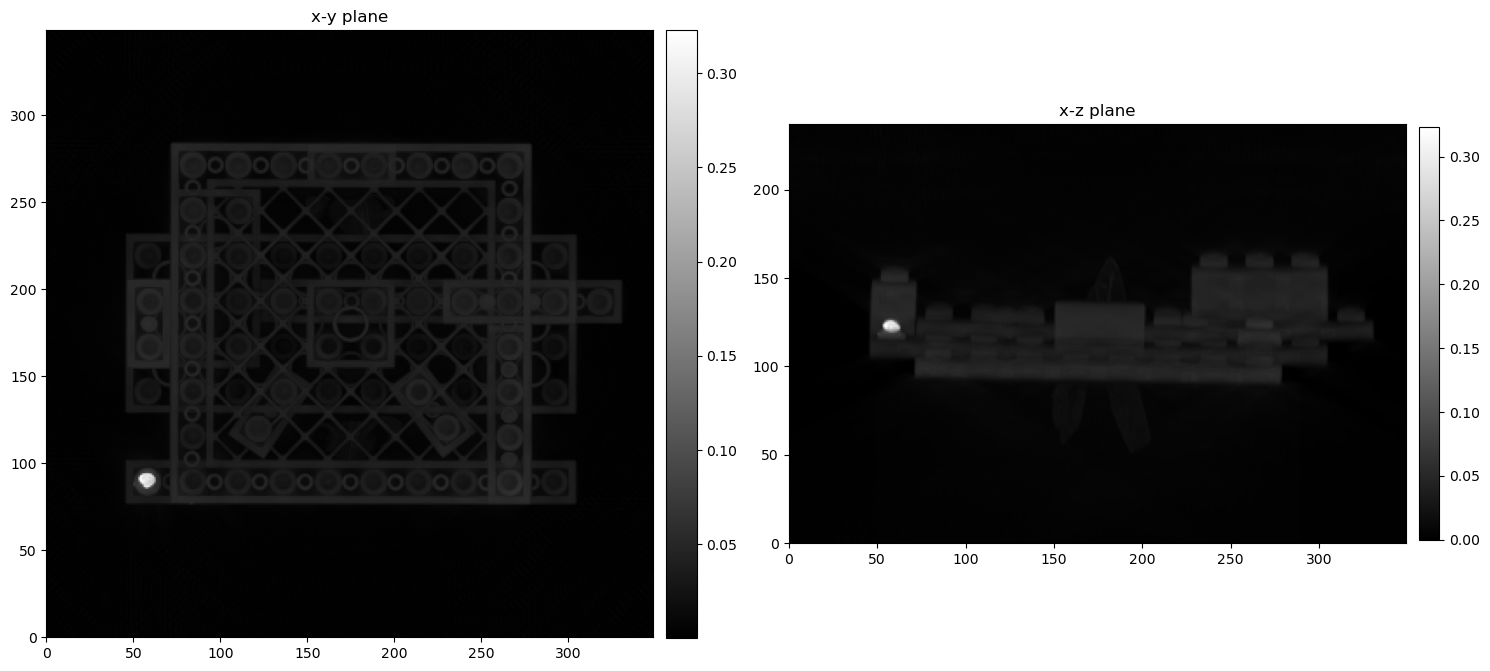

In [13]:
show2D([FDK_reco.max(axis=0),FDK_reco.max(axis=1)],title=['x-y plane','x-z plane'])

We can create a new image geometry and update the `reconstructor` to use it. We get the default image geometry and update both the number of voxels we want to reconstruct, and the offset of this roi.

New image geometry
: Number of channels: 1
channel_spacing: 1.0
voxel_num : x310,y240,z130
voxel_size : x0.30984544426578847,y0.30984544426578847,z0.30984544426578847
center : x4.647681663986827,y0,z-3.098454442657885



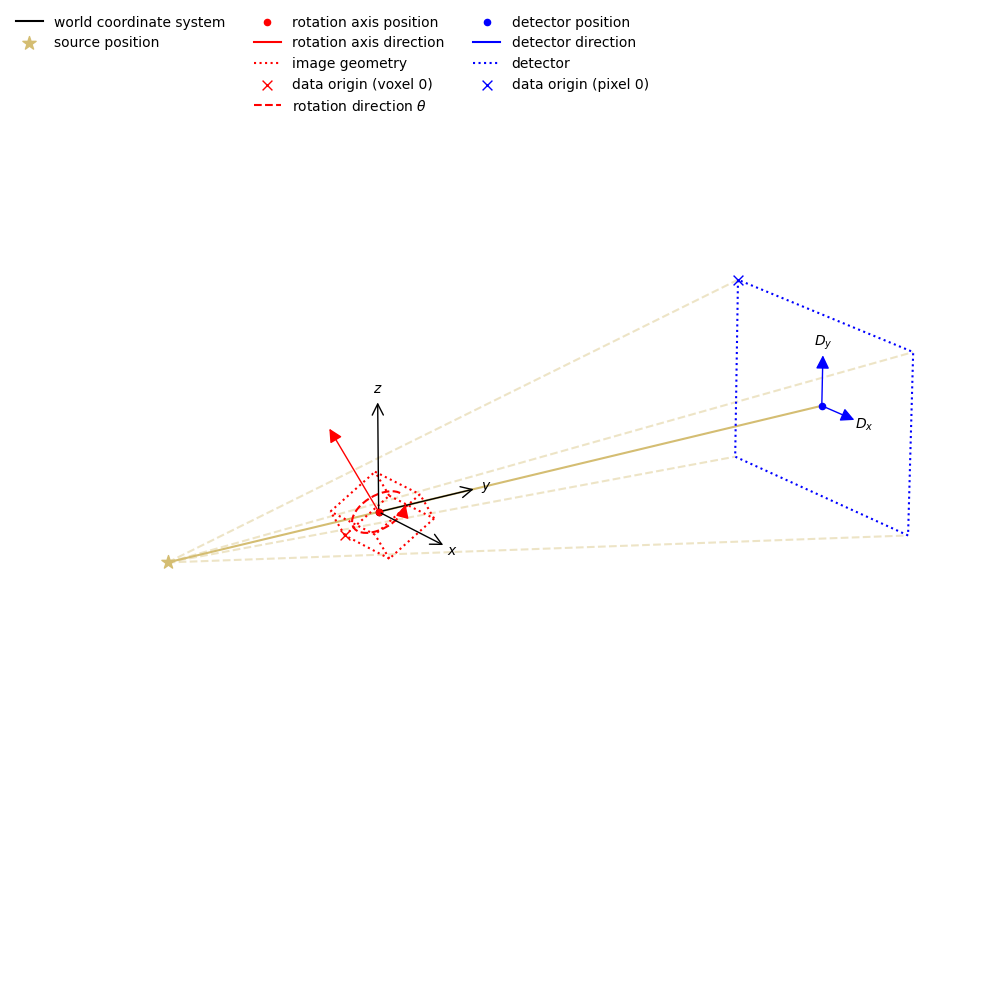

FDK recon

Input Data:
	angle: 359
	vertical: 237
	horizontal: 349

Reconstruction Volume:
	vertical: 130
	horizontal_y: 240
	horizontal_x: 310

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 10
	Filter_inplace: False



interactive(children=(IntSlider(value=65, continuous_update=False, description='vertical', max=129), FloatRang…

IntSlider(value=65, continuous_update=False, description='vertical', max=129)

In [14]:
ag = acq_data.geometry
ig = ag.get_ImageGeometry()
ig.voxel_num_z=130
ig.voxel_num_y=240
ig.voxel_num_x=310

ig.center_x=15*ig.voxel_size_x
ig.center_z=-10*ig.voxel_size_z

print('New image geometry\n:',ig)
show_geometry(ag, ig)

reconstructor.set_image_geometry(ig)
FDK_reco = reconstructor.run()
islicer(FDK_reco, direction='vertical')



Some slices from the FDK reconstruction are shown below. Along the `vertical` direction (x-y plane) we can see some "ghosting" of the object in the nearest layer, i.e., structures from neighbouring layers are partially visible in this layer. If we slice instead along the `horizontal_x` and `horizontal_y` directions (bottom row) we can clearly see missing data wedge artefacts which cause this ghosting. This is usual for laminography datasets and the reconstructions are often analysed only in 2D slices.

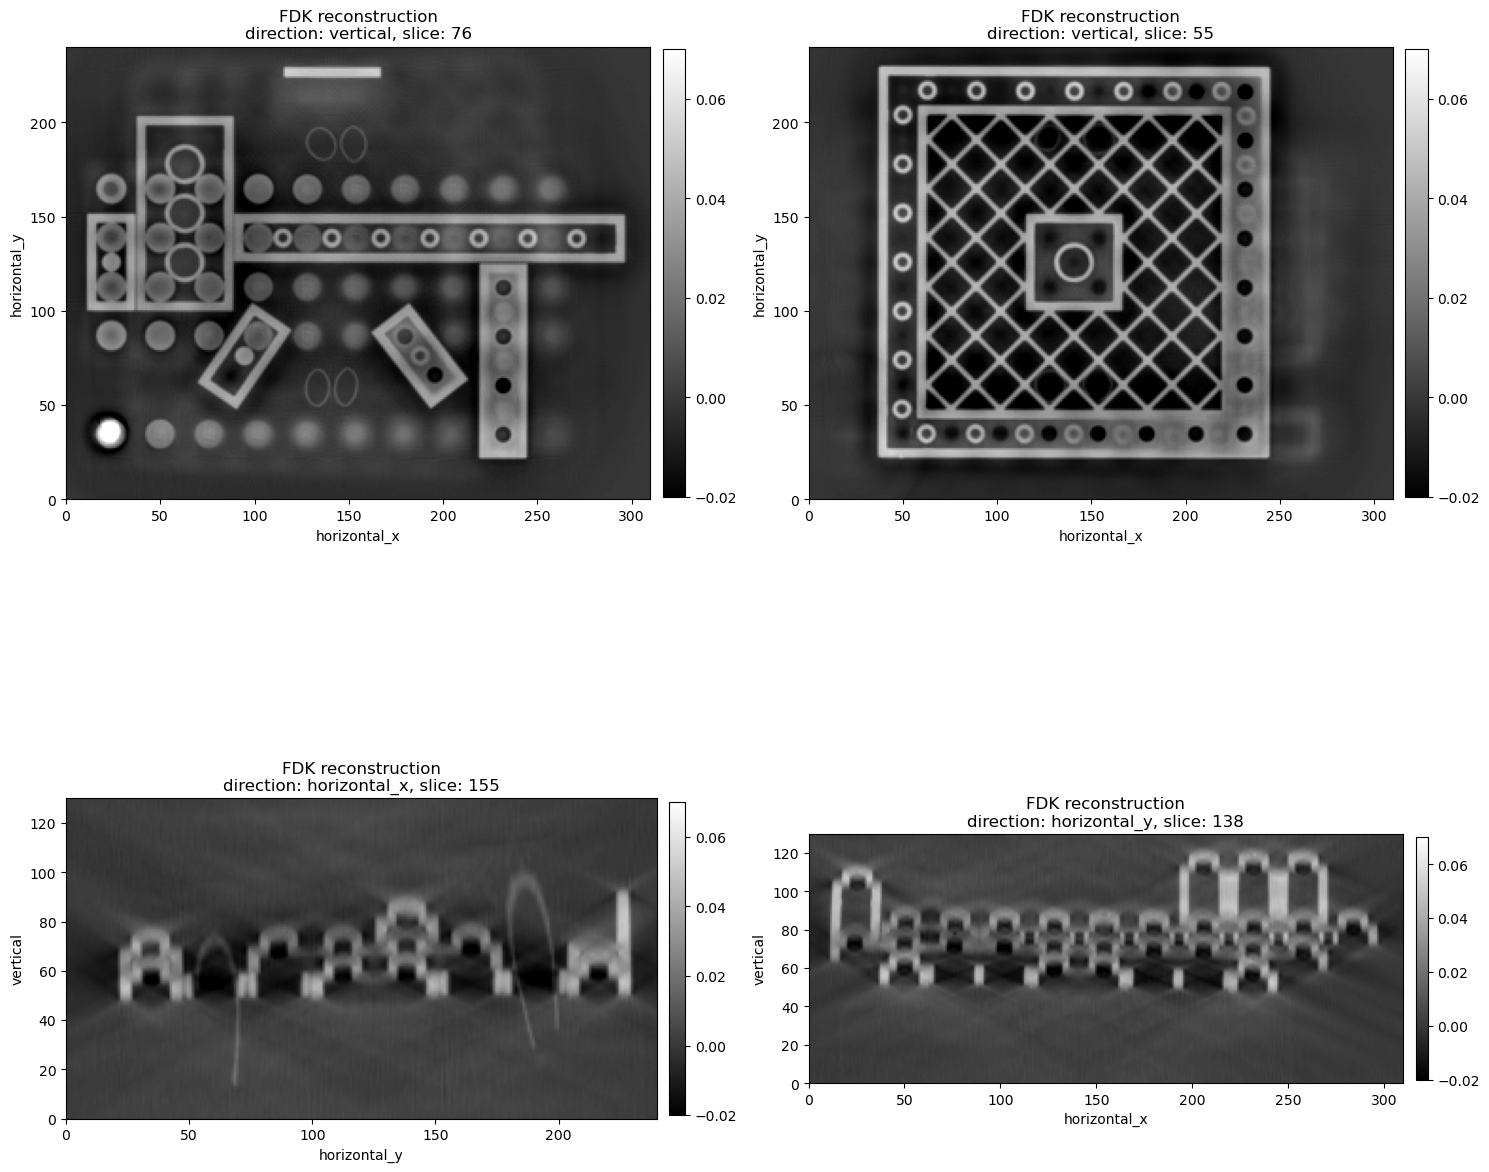

In [15]:
slice_list=[('vertical',76),('vertical',55),('horizontal_x',155),('horizontal_y',138)]
show2D(FDK_reco,slice_list=slice_list, title="FDK reconstruction", fix_range=(-0.02,0.07))

## Reconstructing the data using unregularised Least Squares with FISTA

Using our `ImageGeometry`, `ig`, and `AcquisitionGeometry`, `ag`, we define our projector and a data-fidelity `LeastSquares` term.

We can use FISTA to iteratively solve this reconstruction. As there is no regularisation term we will stop at 100 iterations and observe a similar reconstruction to that obtained by FDK. This example will take approximately 1 minute to run.


In [16]:
Projector = ProjectionOperator(ig, ag)
LS = LeastSquares(A=Projector, b=acq_data)
fista_LS = FISTA(initial=FDK_reco, f=LS, g=ZeroFunction(), max_iteration=1000, update_objective_interval=10)


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.06996e+05
       10       1000         2.107          5.95142e+03
       20       1000         2.112          2.38609e+03
       30       1000         2.115          2.00867e+03
       40       1000         2.113          1.73265e+03
       50       1000         2.117          1.58919e+03
       60       1000         2.114          1.50087e+03
       70       1000         2.118          1.43088e+03
       80       1000         2.118          1.36982e+03
       90       1000         2.121          1.31658e+03
      100       1000         2.121          1.27249e+03
-------------------------------------------------------
      100       1000         2.121          1.27249e+03
Stop criterion has been reached.



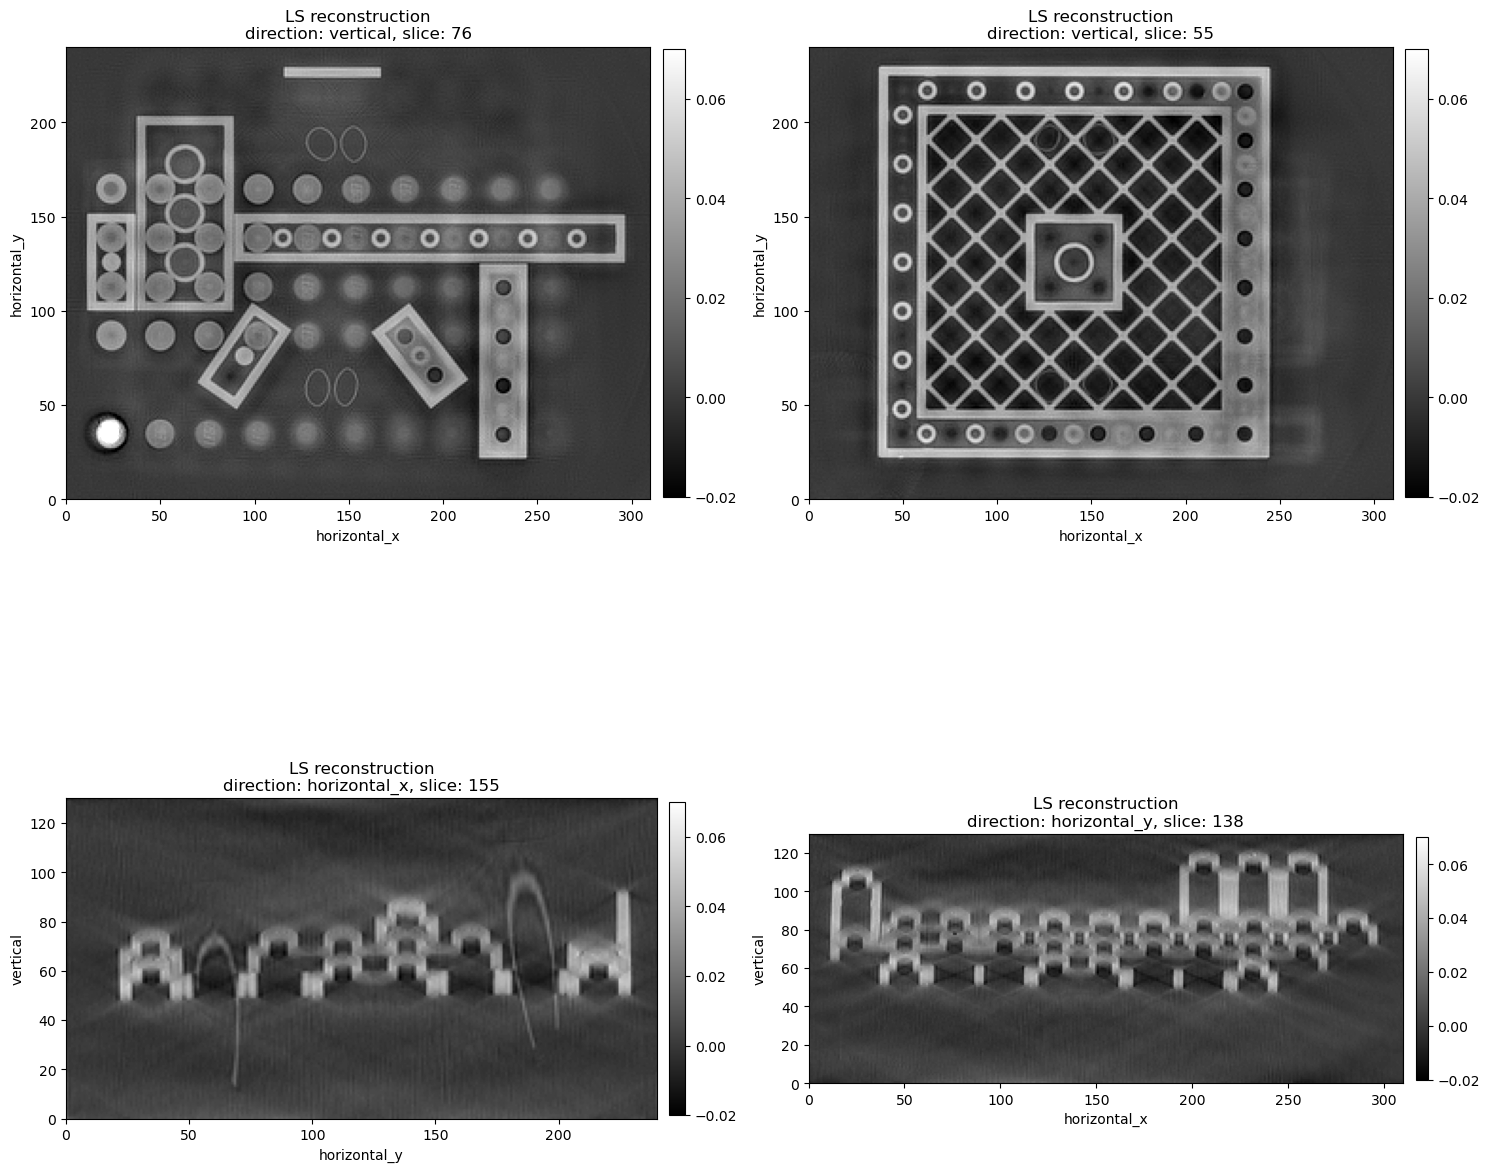

In [17]:
fista_LS.run(100)
LS_reco = fista_LS.solution
show2D(LS_reco,slice_list=slice_list, title="LS reconstruction", fix_range=(-0.02,0.07))


## Reconstructing the data using Total Variation regularised Least Squares with FISTA

We reuse the `LeastSquares` function, but now we also can define a `TotalVariation` function. In this example we use `FGP_TV` from the CCPi-RegularisationToolkit CIL plugin with the `gpu` backend.

We also can add a non-negativity constraint to the function.

Again, we set up and use FISTA to iteratively solve this reconstruction. We run this until the background appears uniform suggesting TV has converged.

For this example we will run 100 iterations, which will take approximately 3 minutes to run.

In [18]:
alpha = 0.05
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')
fista_TV = FISTA(initial=FDK_reco, f=LS, g=TV, max_iteration=1000, update_objective_interval=10)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.08073e+05
       10       1000         6.175          7.81421e+03
       20       1000         6.002          4.22412e+03
       30       1000         5.942          3.30089e+03
       40       1000         5.911          2.86526e+03
       50       1000         5.901          2.63632e+03
       60       1000         5.885          2.51144e+03
       70       1000         5.876          2.44167e+03
       80       1000         5.863          2.40271e+03
       90       1000         5.855          2.37928e+03
      100       1000         5.846          2.36345e+03
-------------------------------------------------------
      100       1000         5.846          2.36345e+03
Stop criterion has been reached.



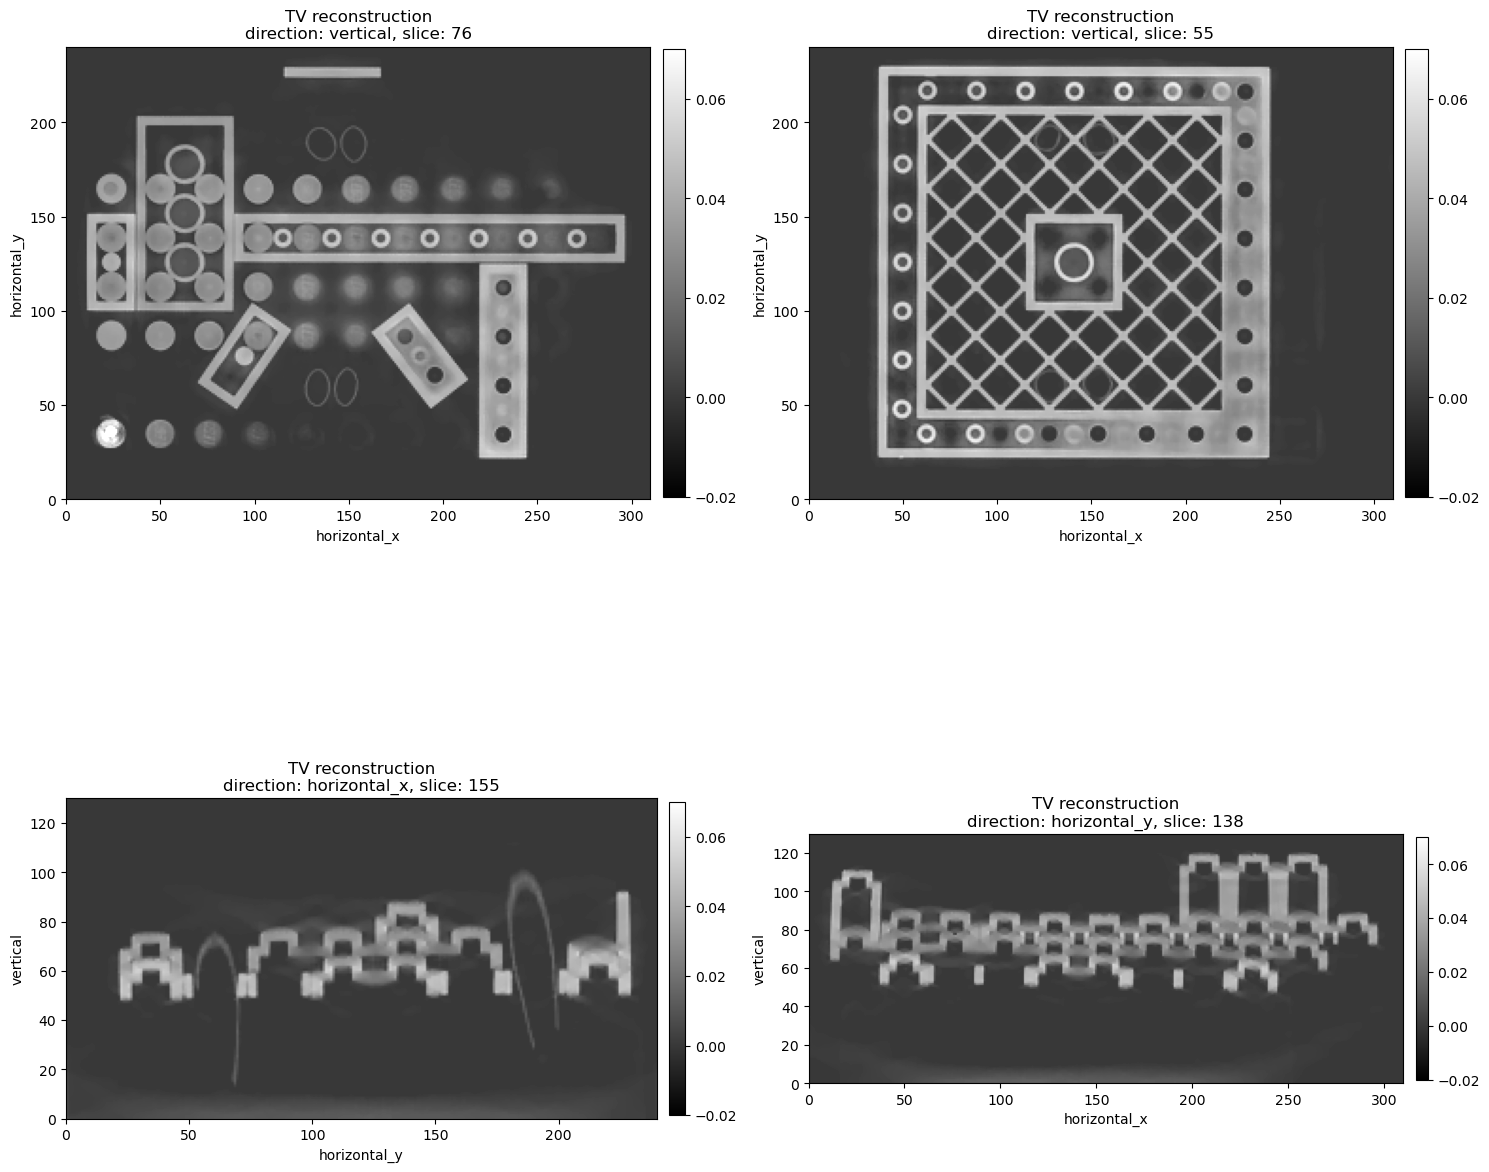

In [19]:
fista_TV.run(100)
TV_reco = fista_TV.solution
show2D(TV_reco,slice_list=slice_list, title="TV reconstruction", fix_range=(-0.02,0.07))

## Comparing the results

We can compare the results of the three reconstructions. Using Total-Variation we have suppressed the missing data artefacts and the ghosting, which would allow us to perform a cleaner segmentation of this sample.

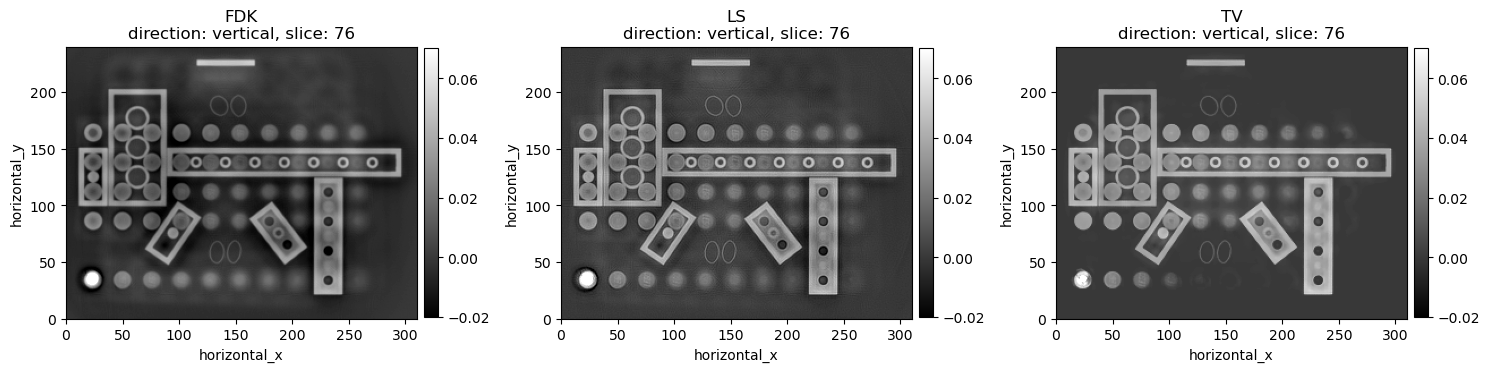

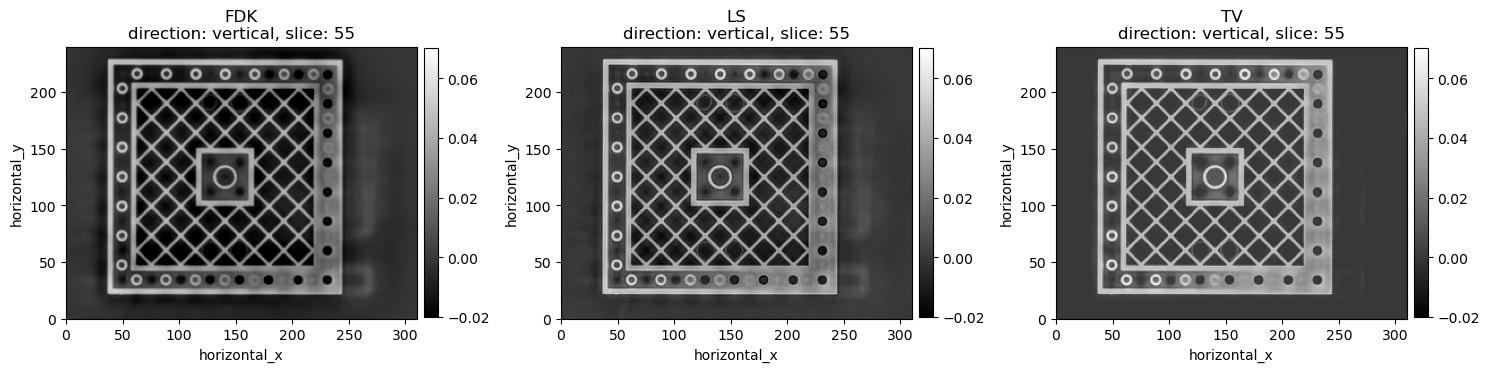

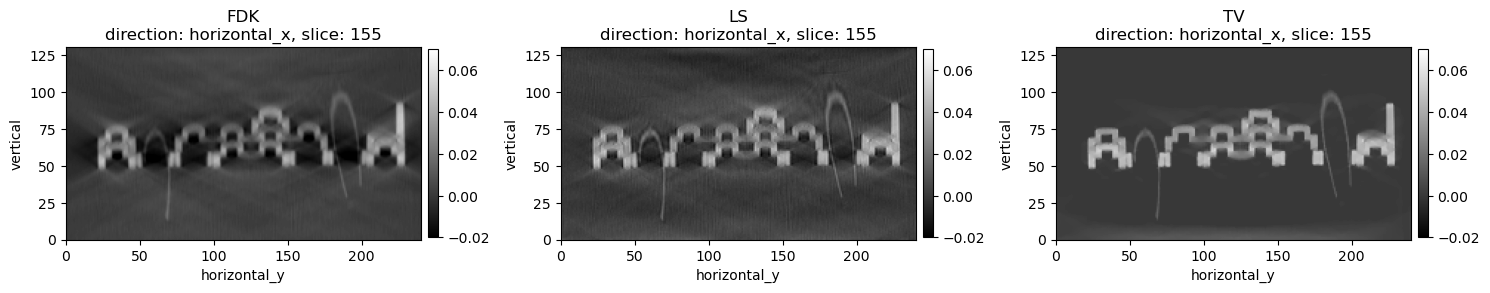

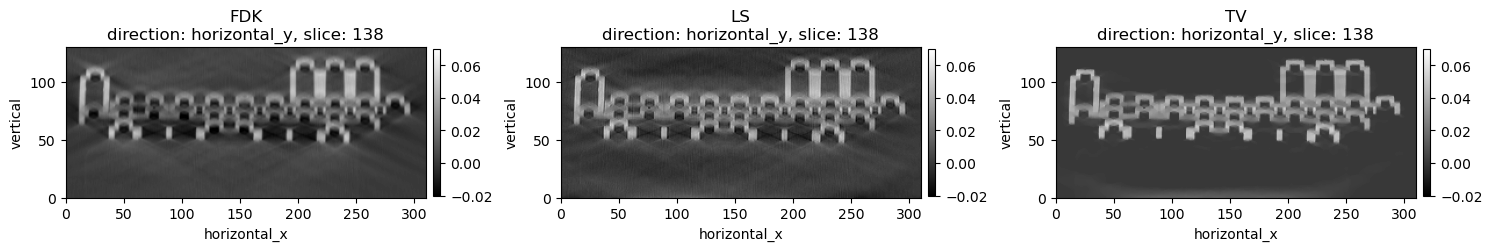

In [20]:
for sl in slice_list:
    show2D([FDK_reco,LS_reco,TV_reco],slice_list=sl, title=['FDK','LS','TV'], fix_range=(-0.02,0.07),num_cols=3)